Marine Copernicus Servie Product ID: MULTIOBS_GLO_PHY_TSUV_3D_MYNRT_015_012

(0.125x0.125º)

In [2]:
import copernicusmarine
import xarray as xr
from dask.diagnostics import ProgressBar
import numpy as np

In [ ]:
min_lon, min_lat, max_lon, max_lat = [-69.6095, -60., -50., -32.4483] 
#estas coordenadas están extraidas del area de la fao 41 la 3.1 3.2 y 2.3
start_date = "2012-12-01"
end_date = None  # hasta la fecha mas reciente disponible

In [ ]:
copernicusmarine.subset(
    dataset_id="cmems_obs-mob_glo_phy_my_0.125deg_P1M-m",
    variables=["mlotst", "so", "to", "ugo", "vgo", "zo"], #mixed layer depth, temperature, u and v components of geostrophic current, sea level
    minimum_latitude=min_lat, minimum_longitude=min_lon,
    maximum_latitude=max_lat, maximum_longitude=max_lon,
    start_datetime=start_date, end_datetime=end_date,
    file_format="zarr",
    output_filename = "cmems_obs-mob_glo_phy_my_0.125deg_P1M-m.zarr",
    output_directory="./resources/copernicus_marine_service",
    chunk_size_limit=50_000_000,
    overwrite=True,
    dry_run=True # False to download and True to only simulate
)

INFO - 2025-12-25T12:32:10Z - Selected dataset version: "202511"
INFO - 2025-12-25T12:32:10Z - Selected dataset part: "default"


ResponseSubset(file_path=WindowsPath('resources/copernicus_marine_service/cmems_obs-mob_glo_phy_my_0.125deg_P1M-m_(1).zarr'), output_directory=WindowsPath('resources/copernicus_marine_service'), filename='cmems_obs-mob_glo_phy_my_0.125deg_P1M-m_(1).zarr', file_size=2867.3603282442746, data_transfer_size=24808.627786259545, variables=['mlotst', 'so', 'to', 'ugo', 'vgo', 'zo'], coordinates_extent=[GeographicalExtent(minimum=-69.5625, maximum=-50.0625, unit='degrees_east', coordinate_id='longitude'), GeographicalExtent(minimum=-59.9375, maximum=-32.5625, unit='degrees_north', coordinate_id='latitude'), TimeExtent(minimum='2012-12-01T00:00:00+00:00', maximum='2024-12-01T00:00:00+00:00', unit='iso8601', coordinate_id='time'), GeographicalExtent(minimum=0.0, maximum=5500.0, unit='m', coordinate_id='depth')], status=<StatusCode.DRY_RUN: '001'>, message=<StatusMessage.DRY_RUN: 'The request was run with the dry-run option. No data was downloaded.'>, file_status='DOWNLOADED')


zo: Geopotential height [m]

ugo: Geostrophic eastward sea water velocity [m/s]

vgo: Geostrophic northward sea water velocity  [m/s]

mlotst: Ocean mixed layer thickness  [m]

so: Sea water salinity  [0.001]

to: Sea water temperature  [°C]

In [5]:
cmems = xr.open_zarr("./resources/copernicus_marine_service/cmems_obs-mob_glo_phy_my_0.125deg_P1M-m.zarr", consolidated=True)

In [6]:
cmems

<xarray.Dataset> Size: 10GB
Dimensions:    (time: 145, latitude: 220, longitude: 157, depth: 50)
Coordinates:
  * time       (time) datetime64[ns] 1kB 2012-12-01 2013-01-01 ... 2024-12-01
  * latitude   (latitude) float32 880B -59.94 -59.81 -59.69 ... -32.69 -32.56
  * longitude  (longitude) float32 628B -69.56 -69.44 -69.31 ... -50.19 -50.06
  * depth      (depth) int16 100B 0 5 10 15 20 25 ... 3500 4000 4500 5000 5500
Data variables:
    mlotst     (time, latitude, longitude) float64 40MB dask.array<chunksize=(145, 220, 157), meta=np.ndarray>
    so         (time, depth, latitude, longitude) float64 2GB dask.array<chunksize=(145, 50, 220, 157), meta=np.ndarray>
    to         (time, depth, latitude, longitude) float64 2GB dask.array<chunksize=(145, 50, 220, 157), meta=np.ndarray>
    ugo        (time, depth, latitude, longitude) float64 2GB dask.array<chunksize=(145, 50, 220, 157), meta=np.ndarray>
    vgo        (time, depth, latitude, longitude) float64 2GB dask.array<chunksize=(145, 50, 220, 157), meta=np.ndarray>
    zo         (time, depth, latitude, longitude) float64 2GB dask.array<chunksize=(145, 50, 220, 157), meta=np.ndarray>
Attributes:
    institution:               CLS
    history:                   2025-10-13 20:10:31 ARMOR3D REP - TSHUV Global...
    title:                     ARMOR3D REP - TSHUVMld Global Ocean Observatio...
    Conventions:               CF-1.0
    copernicusmarine_version:  2.2.5

[########################################] | 100% Completed | 608.61 ms


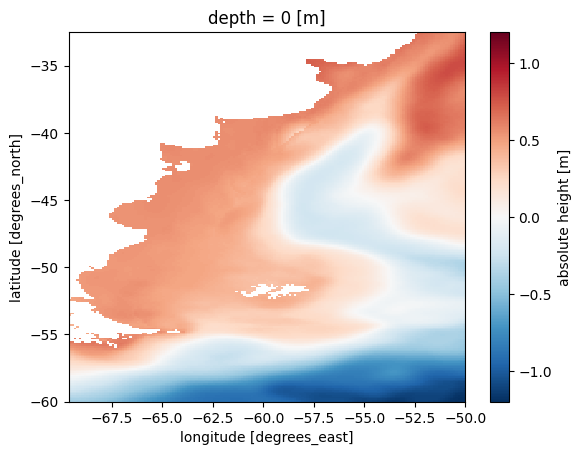

In [14]:
#example of working with zarr data
sst_mean = (cmems["zo"].sel(depth=0, method="nearest").mean(dim="time"))

with ProgressBar():
    sst_mean = sst_mean.compute()
sst_mean.plot()

In [8]:
print(cmems.coords)
# cmems está a 0.125 grados de resolución espacial
# GFW está a 0.1 grados de resolución espacial, hay que reducirle a 0.125
# voy a usar 0.125 grados de resolución espacial para los cálculos

Coordinates:
  * time       (time) datetime64[ns] 1kB 2012-12-01 2013-01-01 ... 2024-12-01
  * latitude   (latitude) float32 880B -59.94 -59.81 -59.69 ... -32.69 -32.56
  * longitude  (longitude) float32 628B -69.56 -69.44 -69.31 ... -50.19 -50.06
  * depth      (depth) int16 100B 0 5 10 15 20 25 ... 3500 4000 4500 5000 5500


In [9]:
cmems_depth = cmems["so"].sel(depth=0, method="nearest")
da_idx = cmems_depth.assign_coords(time=np.arange(cmems_depth.sizes["time"])) #replace datetimes with integer index for polyfit
coeffs = da_idx.polyfit(dim="time", deg=1)
slope_per_step = coeffs["polyfit_coefficients"].sel(degree=1)

# convert to °C/year. If samples are daily: multiply by 365.25
slope_per_decade = slope_per_step * 12 * 10

with ProgressBar():
    slope_per_decade = slope_per_decade.compute()

[########################################] | 100% Completed | 1.47 sms


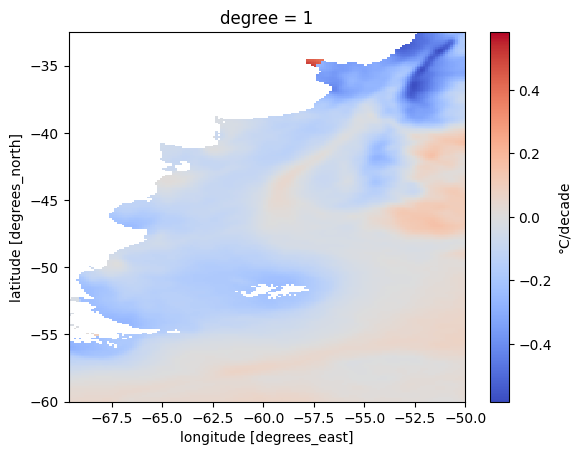

In [10]:
slope_per_decade.plot(cmap='coolwarm', cbar_kwargs={'label': '°C/decade'})